## Visualizing Hurricane Florence

This examples makes a true-color animation of Hurricane Florence by stitching together images from GOES. It builds off this example from [pytroll-examples](https://github.com/pytroll/pytroll-examples/blob/main/satpy/GOES-16%20ABI%20-%20True%20Color%20Animation%20-%20Hurricane%20Florence.ipynb). You can see the output of that example [here](https://twitter.com/PyTrollOrg/status/1039555399433834497).

Here's what our final animation will look like:

<video controls width="80%" src="https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_video/pc-examples-goes-florence.webm">
</video>

In [1]:
import urllib.request

import contextily as ctx
import geopandas
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer
import pystac_client
import rioxarray
import xarray as xr

### Find the storm

First, we need to find where on earth the storm was. The NCEI [International Best Track Archive for Climate Stewardship](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00834) provides files with all the information we need.

In [2]:
file, _ = urllib.request.urlretrieve(
    "https://www.ncei.noaa.gov/data/international-best-track-archive-for-"
    "climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc"
)
# The storm id comes from the text file in
# https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs
# /v04r00/access/netcdf/
# The name of this file changes with the update date, so we can't access it programatically.
STORM_ID = b"2018242N13343"
ds = xr.open_dataset(file)
storm_loc = (ds.sid == STORM_ID).argmax().item()

data = ds.sel(storm=storm_loc)
geometry = geopandas.points_from_xy(data.lon, data.lat)

`geometry` is a geopandas GeoArray with points tracking the location of the storm over time. We'll match those up with the timestamps to plot plot storm's trajectory. We'll also overlay the time period covered by our animation in red.

In [3]:
df = (
    geopandas.GeoDataFrame(
        dict(
            time=pd.to_datetime(data.time).tz_localize("UTC"),
            geometry=geopandas.points_from_xy(data.lon, data.lat),
        )
    )
    .set_crs(4326)
    .dropna()
)

start = pd.Timestamp("2018-09-11T13:00:00Z")
stop = pd.Timestamp("2018-09-11T15:40:00Z")

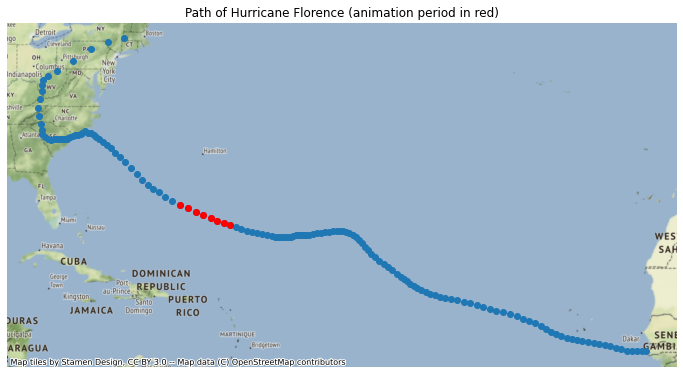

In [4]:
ax = df.to_crs(epsg=3857).plot(figsize=(12, 12))
subset = df[df.time.dt.date == start.date()]
subset.to_crs(epsg=3857).plot(ax=ax, color="r")

ctx.add_basemap(ax)
ax.set_axis_off()
ax.set(title="Path of Hurricane Florence (animation period in red)");

Let's save the bounding box for the subset of points we're animating . We'll use it in our query later on.

In [5]:
bbox = list(subset.total_bounds)

### Get the imagery

Now we'll get the GOES imagery using the Planteary Computer's STAC API. We'll use the `goes-cmi` collection. We'll also have the API filter down the images to just the "mesoscale" images (GOES takes images with various fields of view).

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
search = catalog.search(
    collections=["goes-cmi"],
    bbox=bbox,
    datetime=[start, stop],
    limit=500,
    query={"goes:image-type": {"eq": "MESOSCALE"}},
)
items = search.get_all_items()
signed_items = sorted(
    [planetary_computer.sign(item) for item in items], key=lambda x: x.datetime
)

Let's load and plot the first item, just to make sure we're on the right track.

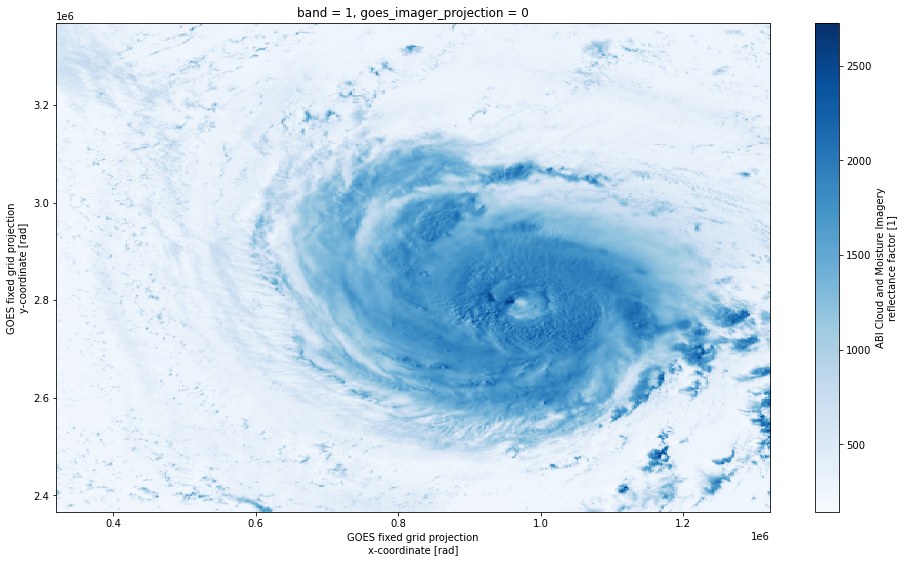

In [7]:
ds = rioxarray.open_rasterio(signed_items[0].assets["C01_2km"].href).load()
ds[0].plot.imshow(figsize=(16, 9), cmap="Blues");

Great. Now we can load all the data for the first three bands (blue, red, and near-infrared)

In [8]:
bands = ["C01_2km", "C02_2km", "C03_2km"]
common_names = [
    items[0].assets[band].extra_fields["eo:bands"][0]["common_name"] for band in bands
]
time = xr.DataArray(
    pd.to_datetime([x.datetime for x in signed_items]).tz_localize(None),
    name="time",
    dims=["time"],
)
arrays = [
    xr.concat(
        [rioxarray.open_rasterio(item.assets[band].href) for band in bands], dim="band"
    ).assign_coords(band=common_names)
    for item in signed_items
]
data = xr.concat(arrays, dim=time).rename("goes")
data

<xarray.DataArray 'goes' (time: 160, band: 3, y: 500, x: 500)>
array([[[[ 545,  530,  537, ...,  348,  280,  277],
         [ 607,  550,  542, ...,  624,  279,  277],
         [ 594,  555,  579, ...,  410,  301,  283],
         ...,
         [ 224,  219,  217, ...,  260,  256,  244],
         [ 219,  222,  217, ...,  244,  243,  245],
         [ 234,  225,  221, ...,  243,  243,  245]],

        [[ 400,  384,  391, ...,  161,   85,   83],
         [ 467,  407,  397, ...,  525,   94,   93],
         [ 452,  414,  437, ...,  237,  113,   96],
         ...,
         [  66,   63,   62, ...,   88,   82,   73],
         [  63,   67,   60, ...,   71,   71,   72],
         [  83,   65,   62, ...,   70,   70,   71]],

        [[ 376,  356,  361, ...,  138,   42,   38],
         [ 444,  381,  371, ...,  480,   47,   50],
         [ 429,  387,  413, ...,  197,   60,   49],
         ...,
...
         ...,
         [ 451,  855,  947, ...,  377,  390,  368],
         [ 627, 1028, 1261, ...,  367,  362,  363],
         [1058, 1047, 1400, ...,  367,  362,  391]],

        [[ 444,  522,  634, ...,  117,  117,  116],
         [ 390,  536,  613, ...,  116,  111,  111],
         [ 339,  479,  546, ...,  115,  113,  113],
         ...,
         [ 221,  714,  805, ...,  119,  142,  109],
         [ 425,  911, 1165, ...,  112,  107,  106],
         [ 940,  902, 1321, ...,  111,  105,  136]],

        [[ 393,  480,  593, ...,   54,   52,   53],
         [ 341,  493,  564, ...,   51,   51,   49],
         [ 292,  432,  494, ...,   51,   50,   51],
         ...,
         [ 173,  699,  811, ...,   70,   91,   57],
         [ 412,  916, 1189, ...,   58,   50,   50],
         [ 977,  932, 1385, ...,   57,   49,   87]]]], dtype=int16)
Coordinates:
  * time                    (time) datetime64[ns] 2018-09-11T13:00:21 ... 201...
  * band                    (band) <U5 'blue' 'red' 'nir09'
  * x                       (x) float64 3.206e+05 3.226e+05 ... 1.321e+06
  * y                       (y) float64 3.367e+06 3.365e+06 ... 2.367e+06
    goes_imager_projection  int64 0
Attributes: (12/14)
    add_offset:             0.0
    ancillary_variables:    DQF_C01
    cell_methods:           t: point area: sum (interval: 0.000028 rad)
    coordinates:            band_id_C01 band_wavelength_C01 t y x
    downsampling_method:    average
    long_name:              ABI Cloud and Moisture Imagery reflectance factor
    ...                     ...
    sensor_band_bit_depth:  10
    standard_name:          toa_lambertian_equivalent_albedo_multiplied_by_co...
    units:                  1
    valid_range:            [   0. 4095.]
    _FillValue:             -1.0
    _Unsigned:              true

GOES doesn't have a true green band, which we need for our true color animation. We'll simulate it with a linear combination of the other bands (See [Bah et. al (2018)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018EA000379) for more on this technique).

In [9]:
green = (
    0.45 * data.sel(band="red")
    + 0.1 * data.sel(band="nir09")
    + 0.45 * data.sel(band="blue")
).assign_coords(band="green")
green

<xarray.DataArray 'goes' (time: 160, y: 500, x: 500)>
array([[[ 462.85,  446.9 ,  453.7 , ...,  242.85,  168.45,  165.8 ],
        [ 527.7 ,  468.75,  459.65, ...,  565.05,  172.55,  171.5 ],
        [ 513.6 ,  474.75,  498.5 , ...,  310.85,  192.3 ,  175.45],
        ...,
        [ 133.8 ,  129.6 ,  128.25, ...,  161.9 ,  156.6 ,  145.95],
        [ 129.9 ,  133.15,  127.05, ...,  144.95,  144.7 ,  146.15],
        [ 147.15,  134.4 ,  130.25, ...,  143.95,  144.05,  145.7 ]],

       [[ 470.  ,  450.9 ,  448.55, ...,  239.7 ,  168.7 ,  165.05],
        [ 518.1 ,  474.05,  507.95, ...,  417.6 ,  170.45,  179.7 ],
        [ 474.75,  467.95,  509.8 , ...,  264.8 ,  186.7 ,  178.85],
        ...,
        [ 132.6 ,  128.7 ,  128.6 , ...,  153.95,  149.6 ,  146.6 ],
        [ 130.35,  132.4 ,  127.05, ...,  146.5 ,  144.8 ,  146.8 ],
        [ 152.55,  134.8 ,  131.8 , ...,  144.15,  144.25,  144.8 ]],

       [[ 482.45,  461.15,  474.1 , ...,  202.3 ,  167.05,  167.35],
        [ 480.85,  479.75,  527.35, ...,  316.15,  169.75,  182.6 ],
        [ 475.75,  499.35,  522.05, ...,  242.45,  182.45,  179.9 ],
        ...,
...
        ...,
        [ 258.  ,  811.5 ,  750.95, ...,  218.2 ,  253.35,  223.05],
        [ 431.4 ,  868.2 , 1116.4 , ...,  232.45,  217.9 ,  219.  ],
        [ 804.25, 1044.05, 1216.5 , ...,  223.9 ,  217.15,  225.55]],

       [[ 497.7 ,  588.4 ,  647.35, ...,  233.15,  232.35,  236.15],
        [ 504.85,  619.  ,  732.  , ...,  231.45,  231.9 ,  229.8 ],
        [ 405.65,  574.4 ,  657.95, ...,  231.55,  229.8 ,  231.45],
        ...,
        [ 287.85,  828.05,  755.1 , ...,  226.25,  256.85,  221.9 ],
        [ 484.85,  901.35, 1188.15, ...,  224.2 ,  216.15,  215.9 ],
        [ 973.6 ,  989.15, 1281.05, ...,  223.7 ,  216.15,  227.85]],

       [[ 535.65,  617.7 ,  722.6 , ...,  233.55,  233.8 ,  235.25],
        [ 480.5 ,  624.4 ,  699.9 , ...,  232.8 ,  231.  ,  231.25],
        [ 433.75,  571.5 ,  638.  , ...,  231.45,  230.9 ,  232.8 ],
        ...,
        [ 319.7 ,  775.95,  869.5 , ...,  230.2 ,  248.5 ,  220.35],
        [ 514.6 ,  964.15, 1210.6 , ...,  221.35,  216.05,  216.05],
        [ 996.8 ,  970.25, 1362.95, ...,  220.8 ,  215.05,  245.85]]])
Coordinates:
  * time                    (time) datetime64[ns] 2018-09-11T13:00:21 ... 201...
  * x                       (x) float64 3.206e+05 3.226e+05 ... 1.321e+06
  * y                       (y) float64 3.367e+06 3.365e+06 ... 2.367e+06
    goes_imager_projection  int64 0
    band                    <U5 'green'

Now we'll normalize the data and apply a gamma correction for plotting.

In [10]:
γ = 2.2

rgb = xr.concat([data, green], dim="band").sel(band=["red", "green", "blue"])
rgb = rgb / rgb.max(dim=["band", "y", "x"])
rgb = np.clip(rgb ** (1 / γ), 0, 1)

Let's check out the first image.

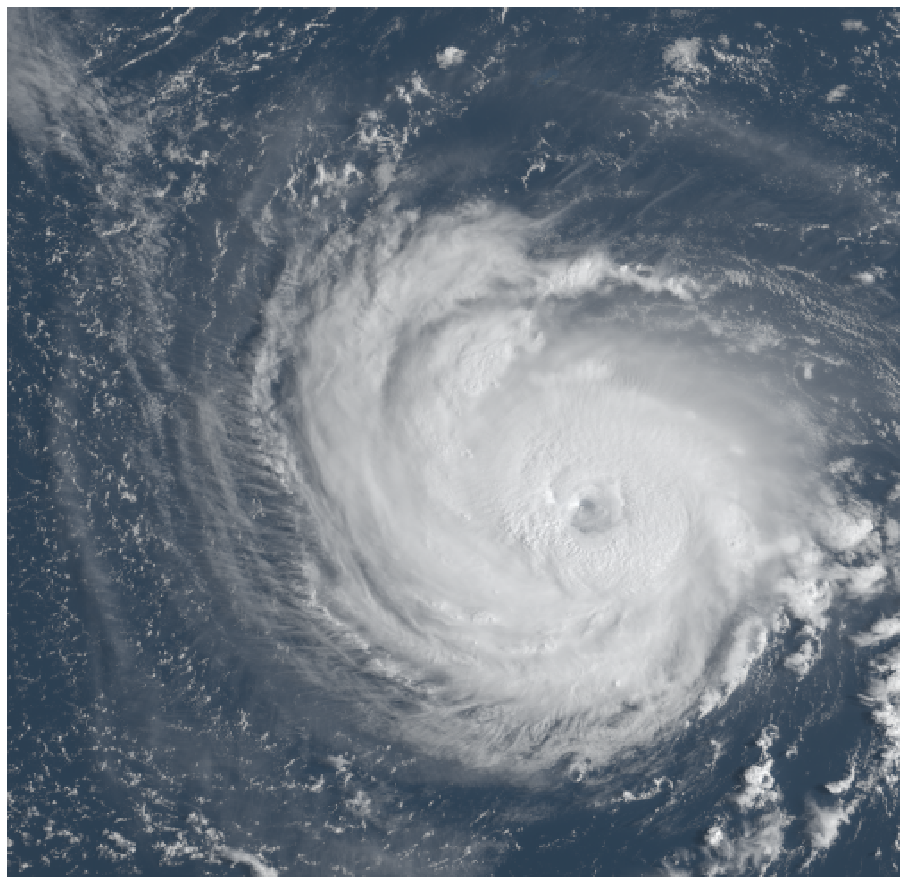

In [11]:
fig, ax = plt.subplots(figsize=(16, 16))
rgb.isel(time=0).plot.imshow(rgb="band", add_labels=False)
ax.set_axis_off()

### Create the animation

We'll use matplotlib's [FuncAnimation](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html) to create the animation.

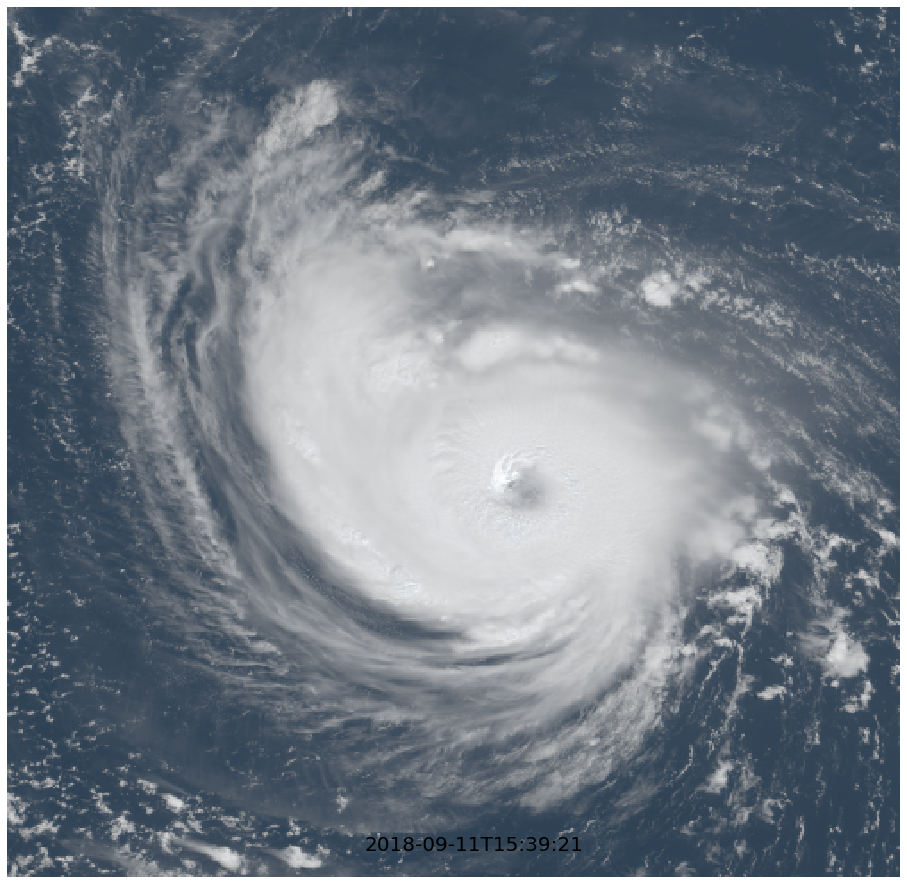

In [12]:
fig, ax = plt.subplots(figsize=(16, 16))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.set_axis_off()

img = rgb[0].plot.imshow(ax=ax, add_colorbar=False, rgb="band", add_labels=False)
label = ax.text(
    0.4,
    0.03,
    pd.Timestamp(rgb.time.data[0]).isoformat(),
    transform=ax.transAxes,
    color="k",
    size=20,
)


def animate(i):
    img.set_data(rgb[i].transpose("y", "x", "band"))
    label.set_text(pd.Timestamp(rgb.time.data[i]).isoformat())
    return img, label


ani = animation.FuncAnimation(fig, animate, frames=len(rgb), interval=120)
ani.save(
    "goes.mp4",
    fps=15,
    extra_args=["-vcodec", "libx264"],
    savefig_kwargs=dict(pad_inches=0, transparent=True),
)

In [ ]:
from IPython.display import Video

Video("goes.mp4")

### Next steps

Learn more about GOES and using the Planetary Computer

* [GOES quickstart](../datasets/goes/goes-example.ipynb)
* [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/)